In [1]:
# =============
#   PAQUETES
# =============
import numpy as np        
import sympy as sp
from scipy.signal import ZerosPolesGain, TransferFunction, bode
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# ==========================
#   CARACTERÍSTICAS LM324
# ==========================
Ad0_dB    = 100       #  Ganancia Diferencial en dB
Ad0_veces = 100E3     #  Ganancia Diferencial en veces
fT        = 1e6       #  Frecuencia de Cruce
fp1       = 10        #  1er Polo
fp2       = 5.06E6    #  2do Polo

# ===========================
#   CARACTERÍSTICAS LM6181
# ===========================
RT   = 2.37E6      #  Transresistencia
CT   = 4.8E-12     #  Transcapacitancia
fpx  = 33.34E6     #  Polo del CFA sin Compensador
Avf2 = 20          #  Ganancia del CFA sin Compensador
R2   = 994.6       #  Resistencia R2 de la Red de Realimentación de AO2 sin Compensador
R1   = 52.3        #  Resistencia R1 de la Red de Realimentación de AO2 sin Compensador

# =====================
#   ESPECIFICACIONES
# =====================
Avf_dB    = 20       #  Ganancia de Lazo Cerrado en dB
Avf_veces = 10       #  Ganancia de Lazo Cerrado en veces

# ============================
#   COMPENSADOR CERO - POLO
# ============================
fzc  = 5.06E6        #  Cero del Compensador cancela 2do Polo del VFA
fpc  = 2 * 5.06E6    #  Polo del Compensador a una Octava del Cero
Comp = fzc / fpc     #  Atenuación producida por el Compensador
# Para ubicar adecuadamente fzc y fpc
# Se debe cumplir que: R3 = R4, siendo: R3 -> Resistencia del Compensador en Paralelo al Capacitor
#                                       R4 -> Resistencia del Compensador a Masa
R3 = 1E3
R4 = 1E3
# Y para hallar C:
C = 1 / (2 * np.pi * fzc * R3)    # Capacitor del Compensador

# ===========================
#   AMPLIFICADOR COMPUESTO
# ===========================

# =================
#   DESARROLLOS
# =================
# Para lograr una Ganancia de Lazo Cerrado de 20 [dB]
# Se debe cumplir que: Rf = 9 * Ri
Ri = 1E3              #  Resistencia Ri
Rf = 9 * Ri           #  Resistencia Rf
# Entonces:
K  = Ri / (Ri + Rf)   #  Cantidad de Realimentación

# Para compensar la Atenuación
Avf2 = Avf2 / Comp
# Entonces:
R2 = 994.6            #  Manteniendo ubicación de fpx
R1 = R2 / (Avf2 - 1)  #  Nuevo valor de R1 de la Red de Realimentación de AO2

# Hallar fg por GBW:
fg = Ad0_veces * Avf2 * Comp * fp1 * K
# El Mp queda:
Mp_s = (np.radians(180 - 90) - np.arctan(fg / fpx) - np.arctan(fg / fpc)) * 180 / np.pi

# Cálculos Sistema Compuesto
To   = K * Ad0_veces * Avf2 * Comp   #  Ganancia de Lazo en Banda de Paso
fp   = np.sqrt(To * fp1 * fpc)       #  Frecuencia de Polo del Sistema
Dp   = fpc / fp1                     #  Distancia entre Polos del Sistema
Qp_s = np.sqrt(To / Dp)              #  Factor de Calidad del Polo del Sistema
fH   = 10**(3 / 20) * fg             #  Ancho de Banda a -3dB

# ==========================
#   BLOQUE N°1: AO1 - VFA
# ==========================
num_1 = [Ad0_veces * (2 * np.pi)**2 * fp1 * fp2]
den_1 = [1, 2 * np.pi * (fp1 + fp2), (2 * np.pi)**2 * fp1 * fp2]
G1    = TransferFunction(num_1, den_1)

# ==========================
#   BLOQUE N°2: COMPENSADOR
# ==========================
num_2 = [Comp * 2 * np.pi * fpc, Comp * (2 * np.pi)**2 * fpc * fzc]
den_2 = [2 * np.pi * fzc, (2 * np.pi)**2 * fpc * fzc]
G2    = TransferFunction(num_2, den_2)

# ==========================
#   BLOQUE N°3: AO2 - CFA
# ==========================
num_3 = [Avf2 * 2 * np.pi * fpx]
den_3 = [1, 2 * np.pi * fpx]
G3    = TransferFunction(num_3, den_3)

# =======================
#   SISTEMA COMPUESTO
# =======================
num_comp = np.convolve(num_1, num_2)
den_comp = np.convolve(den_1, den_2)
num_comp = np.convolve(num_comp, num_3)
den_comp = np.convolve(den_comp, den_3)
Gt       = TransferFunction(num_comp, den_comp)

# =========
#   1/K
# =========
num_k = [1]
den_k = [K]
Gk    = TransferFunction(num_k, den_k)

# ================
#   RESULTADOS
# ================
print("========== AO1 ==========")
print(f"Ri = {Ri/1E3:.0f} kΩ")
print(f"Rf = {Rf/1E3:.0f} kΩ")
print(f"1/K = {1/K:.0f} veces")

print("========== AO2 ==========")
print(f"R1 = {R1:.1f} Ω")
print(f"R2 = {R2:.1f} Ω")
print(f"Avf2 = {Avf2:.0f} veces")
print(f"fpx = {fpx/1E6:.2f} MHz")

print("======= Compensador =======")
print(f"R3 = {R3/1E3:.0f} kΩ")
print(f"R4 = {R4/1E3:.0f} kΩ")
print(f"C = {C/1E-12:.2f} pF")
print(f"Atenuación = {Comp:.1f} veces")
print(f"fzc = {fzc/1E6:.2f} MHz")
print(f"fpc = {fpc/1E6:.2f} MHz")

print("========== Resultados ==========")
print(f"Ancho de Banda Potencial:   fg = {fg/1E6:.0f} MHz")
print(f"Ganancia de Lazo:           To = {To:.0f} veces")
print(f"Distancia entre Polos:      Dp = {Dp:.0f}")
print(f"Frecuencia del Polo:        fp = {fp/1E6:.2f} MHz")
print(f"Factor de Calidad del Polo: Qp = {Qp_s:.3f}")
print(f"Ancho de Banda a -3dB:      fH = {fH/1E6:.2f} MHz")
print(f"Margen de Fase:             Mp = {Mp_s:.2f} ")

========== AO1 ==========
Ri = 1 kΩ
Rf = 9 kΩ
1/K = 10 veces
========== AO2 ==========
R1 = 25.5 Ω
R2 = 994.6 Ω
Avf2 = 40 veces
fpx = 33.34 MHz
======= Compensador =======
R3 = 1 kΩ
R4 = 1 kΩ
C = 31.45 pF
Atenuación = 0.5 veces
fzc = 5.06 MHz
fpc = 10.12 MHz
========== Resultados ==========
Ancho de Banda Potencial:   fg = 2 MHz
Ganancia de Lazo:           To = 200000 veces
Distancia entre Polos:      Dp = 1012000
Frecuencia del Polo:        fp = 4.50 MHz
Factor de Calidad del Polo: Qp = 0.445
Ancho de Banda a -3dB:      fH = 2.83 MHz
Margen de Fase:             Mp = 75.39 


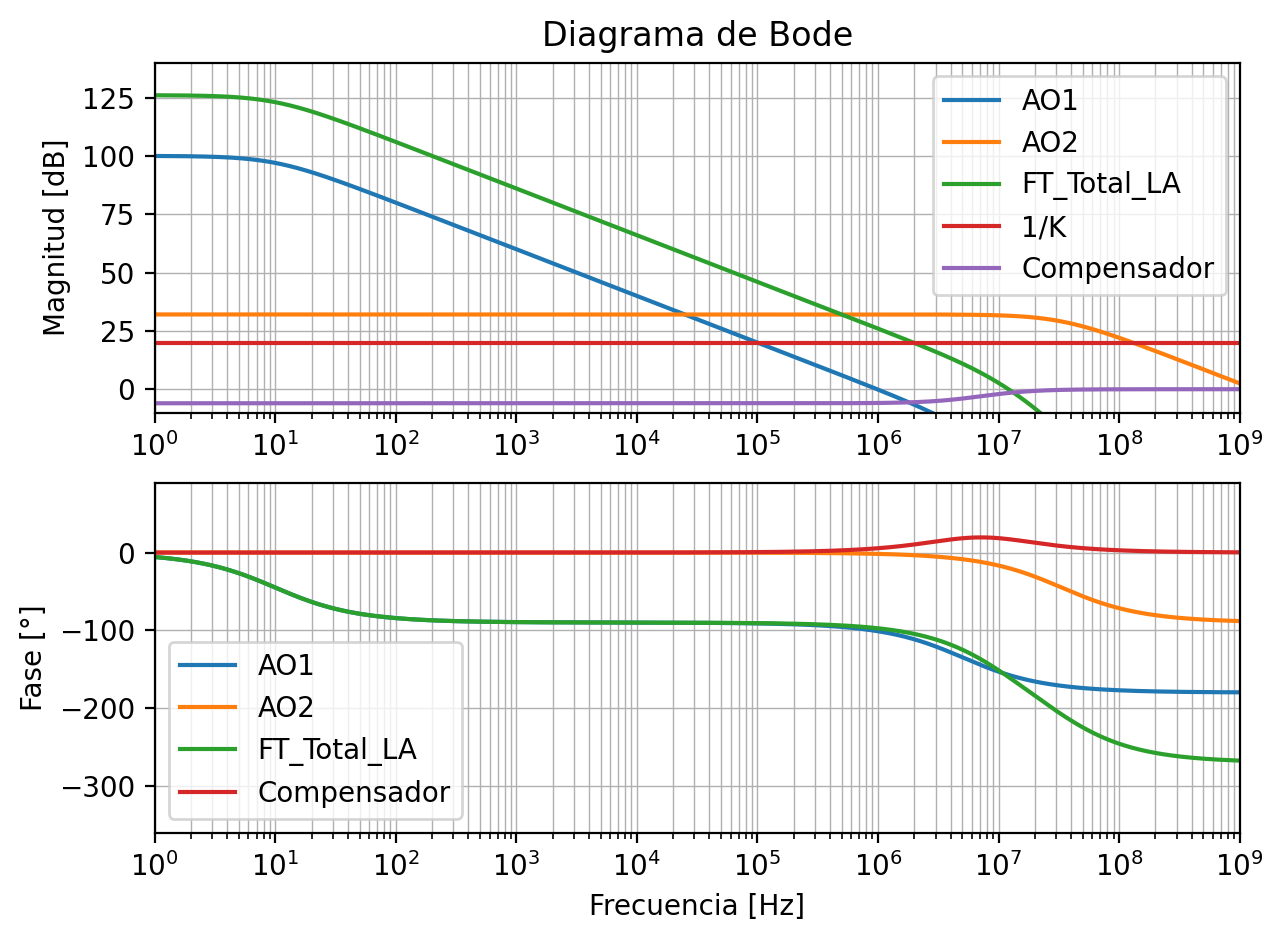

In [3]:
# ====================================
#   DIAGRAMA DE BODE DE CADA BLOQUE
# ====================================
rango_f = np.logspace(0,9,1000)

# ===========
#   MÓDULO
# ===========
plt.figure(figsize = (7, 5), dpi=200)

plt.subplot(2, 1, 1)
w, mag, phase = G1.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, mag, label='AO1')
plt.title("Diagrama de Bode")
plt.ylabel("Magnitud [dB]")
plt.xlim(1e0, 1e9)                                           
plt.ylim(-10, 140)
plt.grid(which='both', linewidth=0.5)

w, mag, phase = G3.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, mag, label='AO2')

w, mag, phase = Gt.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, mag, label='FT_Total_LA')

w, mag, phase = Gk.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, mag, label='1/K')

w, mag, phase = G2.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, mag, label='Compensador')

plt.legend()

# =========
#   FASE
# =========
plt.subplot(2, 1, 2)
w, mag, phase = G1.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, phase, label='AO1')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Fase [°]")
plt.xlim(1e0, 1e9)                                           
plt.ylim(-360, 90)
plt.grid(which='both', linewidth=0.5)

w, mag, phase = G3.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, phase, label='AO2')

w, mag, phase = Gt.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, phase, label='FT_Total_LA')

w, mag, phase = G2.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, phase, label='Compensador')

plt.legend()


In [4]:
# ===================================
#   RESPUESTA AL ESCALÓN UNITARIO
# ===================================
# De acuerdo a lo obtenido en Matlab:

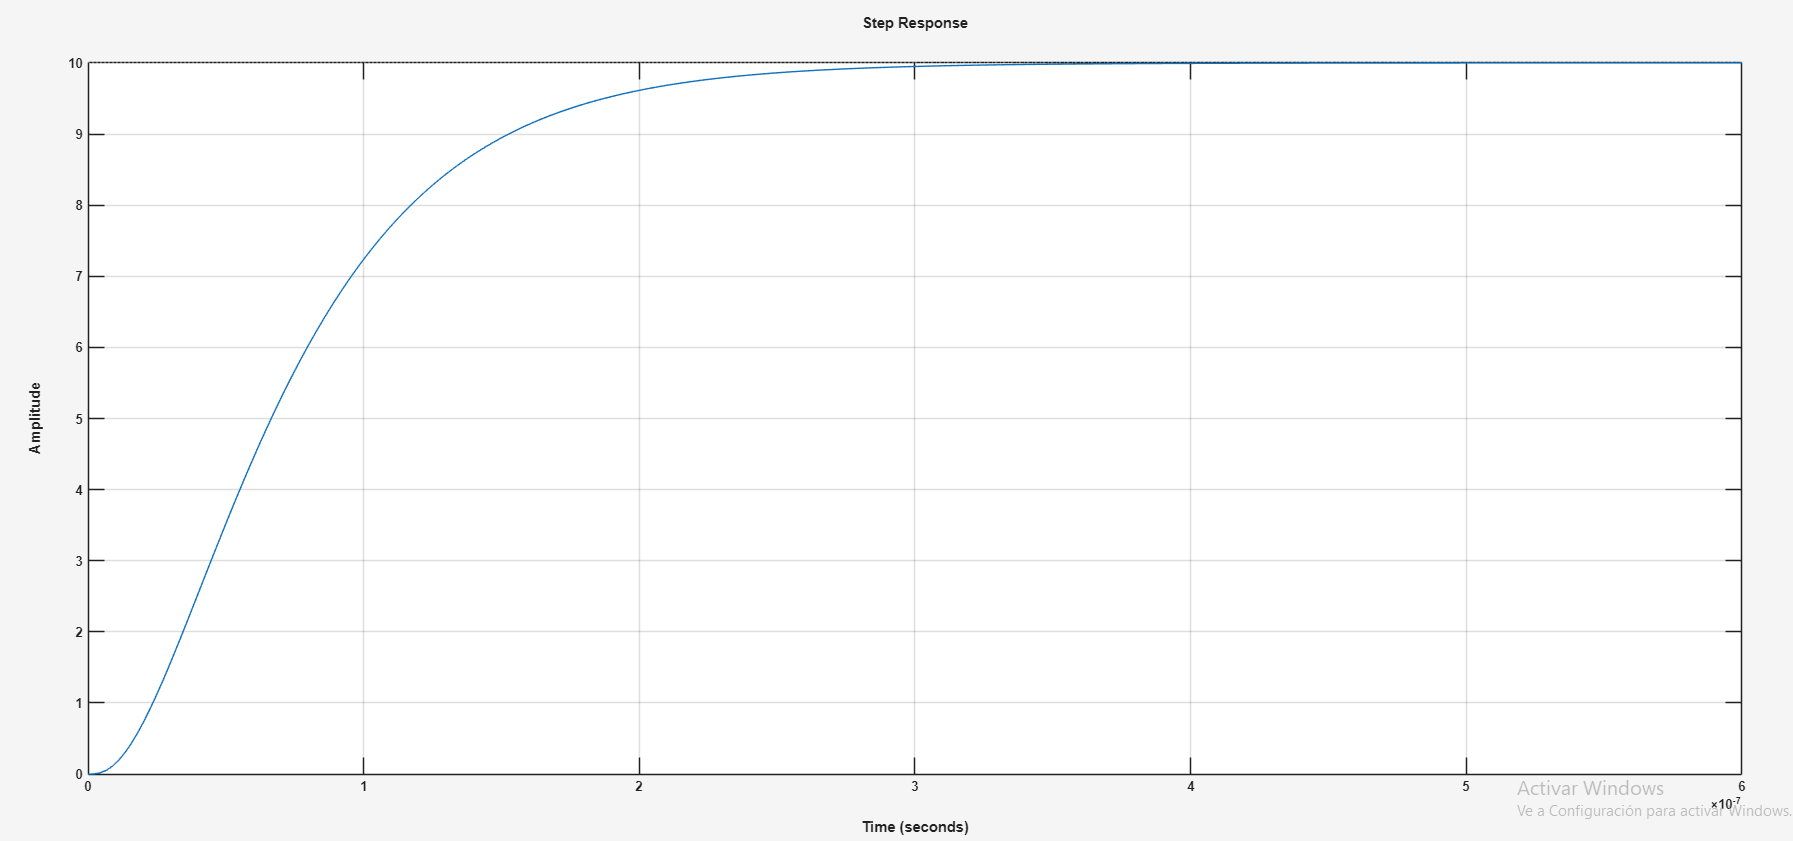

In [5]:
# ===================================
#   RESPUESTA AL ESCALÓN UNITARIO
# ===================================
# De acuerdo a lo obtenido en LTspice:
Peak          = 10.063728
Overshoot     = (Peak - 10) / 10 * 100

# ===================================
#   ESTIMACIÓN DEL MARGEN DE FASE
# ===================================
# Calculamos Zeta (Coeficiente de Amortiguamiento):
Zeta = - np.log(Overshoot / 100) / np.sqrt(((np.pi)**2 + (np.log(Overshoot / 100))**2))
# Calculamos Mp:
Mp_step = np.degrees(np.arctan(2 * Zeta / (np.sqrt(np.sqrt(1 + 4 * Zeta**4) - 2 * Zeta**2))))

print("========== Resultados ==========")
print(f"Coeficiente de Amortiguamiento:   Zeta = {Zeta:.2f}")
print(f"Margen de Fase Estimado:            Mp = {Mp_step:.2f}°")

========== Resultados ==========
Coeficiente de Amortiguamiento:   Zeta = 0.85
Margen de Fase Estimado:            Mp = 71.78°
